In [35]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# using a pretrained model 

In [2]:
model = keras.applications.resnet.ResNet50(weights='imagenet')


In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

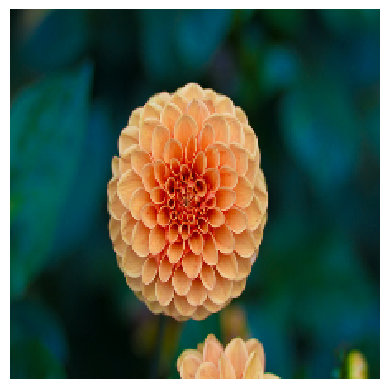

In [5]:
# reize image shape to shape on input_shape of resnet 50
images_resized = tf.image.resize(images, [224,224])
plot_color_image(images_resized[1])

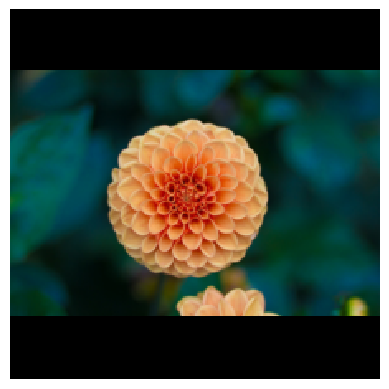

In [6]:
# Resize with pad
images_resized_pad = tf.image.resize_with_pad(images,224,224,antialias=True)
plot_color_image(images_resized_pad[1])

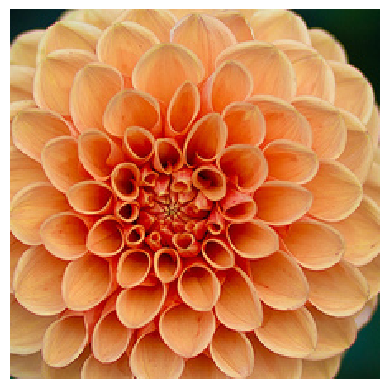

In [7]:
images_resized_crop_or_pad = tf.image.resize_with_crop_or_pad(images,224,224)
plot_color_image(images_resized_crop_or_pad[1])

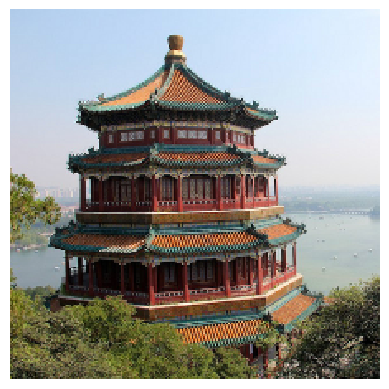

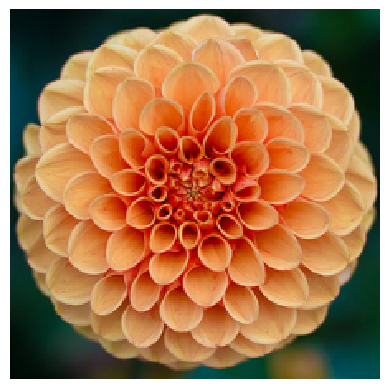

In [8]:
# reize approrch the size definition

# crop size
cihna_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized_and_crop = tf.image.crop_and_resize(images, [cihna_box, flower_box], [0,1], [224,224])
plot_color_image(image_resized_and_crop[0])
plt.show()
plot_color_image(image_resized_and_crop[1])
plt.show()

In [9]:
images.shape

(2, 427, 640, 3)

In [10]:
images_resized_pad.shape

TensorShape([2, 224, 224, 3])

In [11]:
images_resized.shape

TensorShape([2, 224, 224, 3])

In [12]:
images_resized_crop_or_pad.shape


TensorShape([2, 224, 224, 3])

In [13]:
image_resized_and_crop.shape

TensorShape([2, 224, 224, 3])

In [14]:
inputs = keras.applications.resnet50.preprocess_input(image_resized_and_crop * 255) #preprocess input
Y_proba = model.predict(inputs)

1/1 [==============================] - 8s 8s/step


In [15]:
print(Y_proba)
print(Y_proba.shape)
print(np.argmax(Y_proba,axis=1))

[[7.3529711e-09 2.1550377e-08 7.4669257e-09 ... 1.7053464e-09
  1.1168397e-07 3.3814896e-08]
 [2.3453514e-07 7.0248570e-06 4.0475337e-07 ... 5.3985412e-05
  3.6657166e-05 1.3363607e-04]]
(2, 1000)
[698 883]


In [16]:
top_k = keras.applications.resnet50.decode_predictions(Y_proba,top=3)
for image_index in range(len(images)):
    print(f"Images #{image_index}")
    for class_id, name, Y_proba in top_k[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id,name,Y_proba *100))
    print()

Images #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.08%
 n03781244 - monastery    11.69%

Images #1
 n04522168 - vase         53.97%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.96%



# Pretrained Models for Transfer Learning


In [17]:
import tensorflow_datasets as tfds

In [18]:
dataset, info = tfds.load("tf_flowers",as_supervised=True, with_info=True)

In [19]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [20]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [21]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [22]:
n_classes = info.features['label'].num_classes
n_classes

5

In [23]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [24]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split = ["train[:10%]", "train[10%:25%]","train[25%:]"],
    as_supervised=True
)

In [25]:
test_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
valid_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
train_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

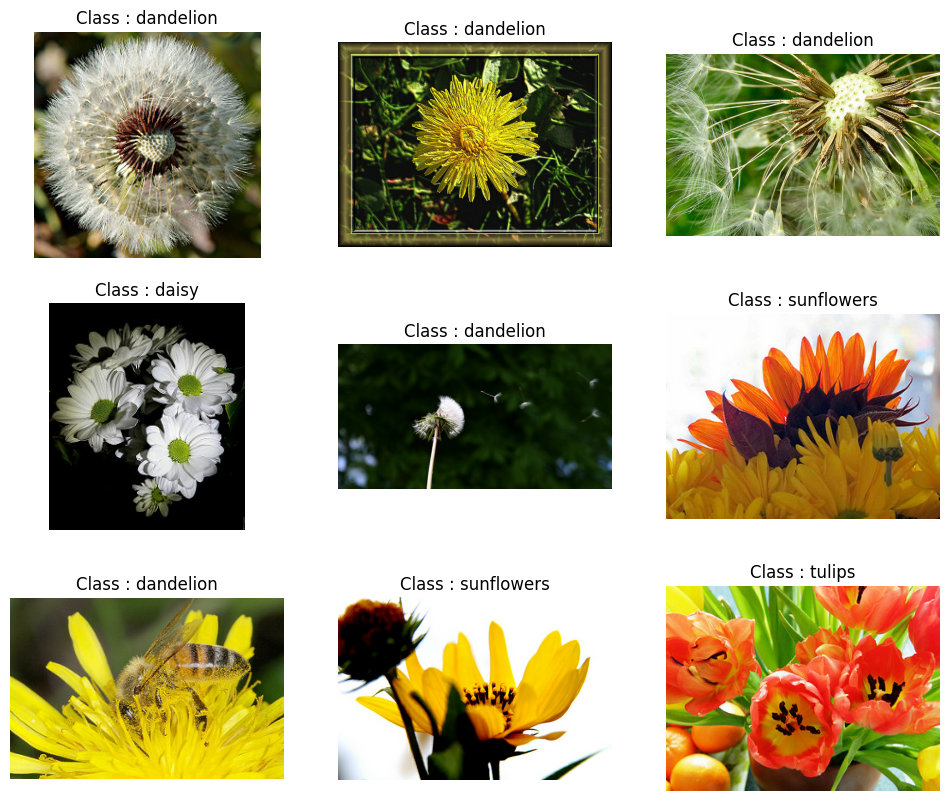

In [30]:
plt.figure(figsize=(12,10))
index = 0
for image, label in train_set_raw.take(9):
    index +=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title("Class : {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Basic Preprocessing

In [31]:
def preprocess(image,label):
    resized_image = tf.image.resize(image,[224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

### Data augmentation

In [32]:
def central_crop(image):
    shape = tf.shape(image) # take a shape from image
    min_dim = tf.reduce_min([shape[0], shape[1]]) # take a shape minimum
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = (shape[0] - top_crop)
    left_crop = (shape[1] - min_dim) // 4
    right_crop = (shape[1] - left_crop)
    return image[top_crop:bottom_crop, left_crop:right_crop]
    

In [33]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image,[min_dim,min_dim,3])    

In [34]:
def preprocess(image, label, randomize = False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else :
        cropped_image = central_crop(image)
    resized_image= tf.image.resize(cropped_image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [36]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set =  test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

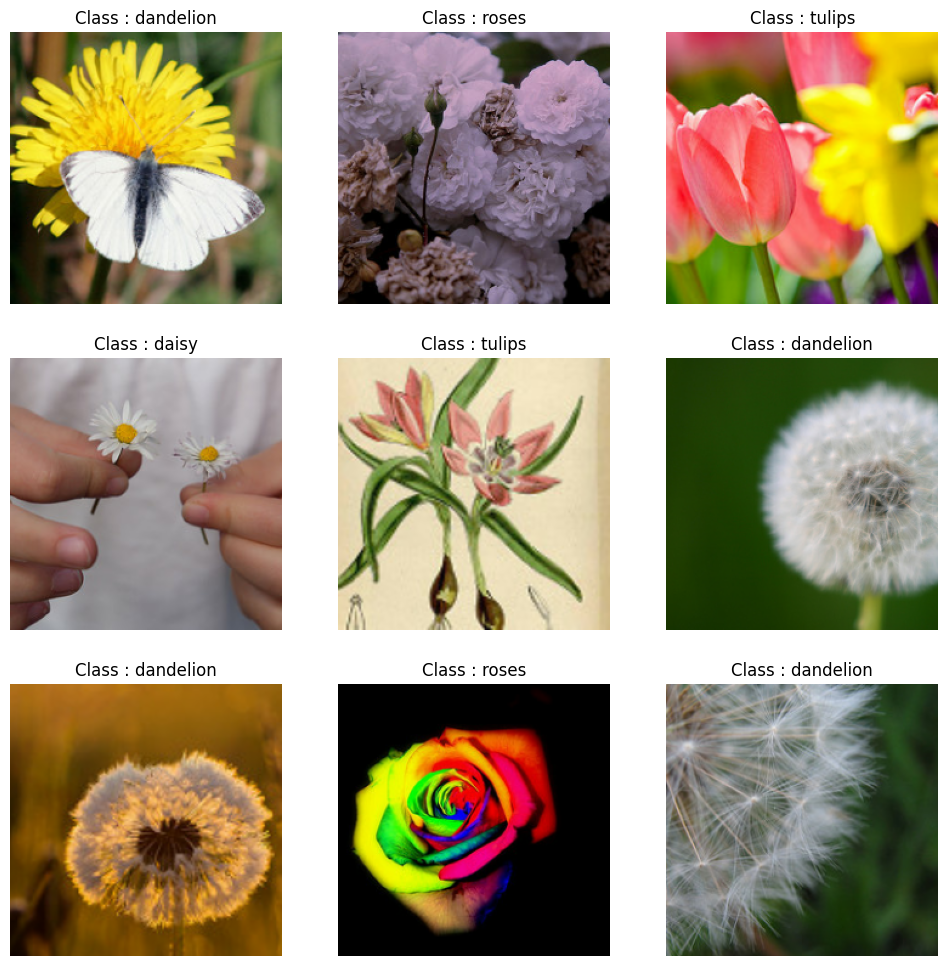

In [39]:
plt.figure(figsize=(12,12))
for x_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 5e-1)
        plt.title(f"Class : {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

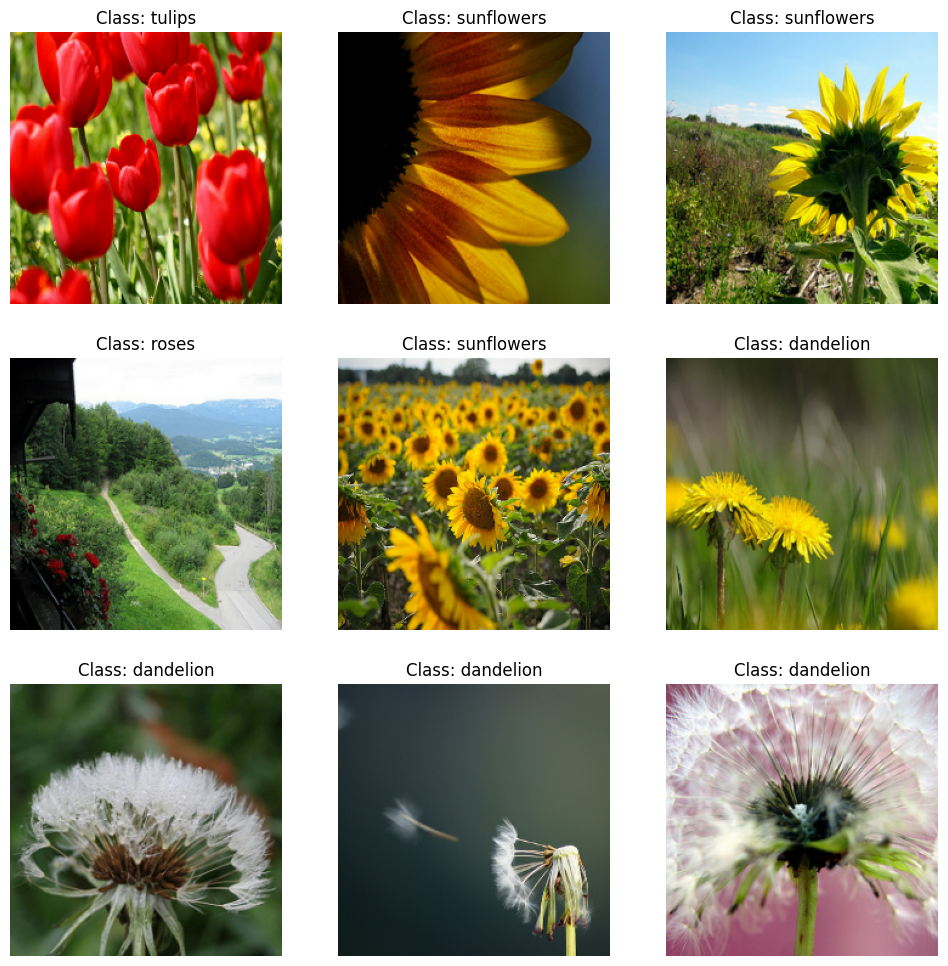

In [40]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()